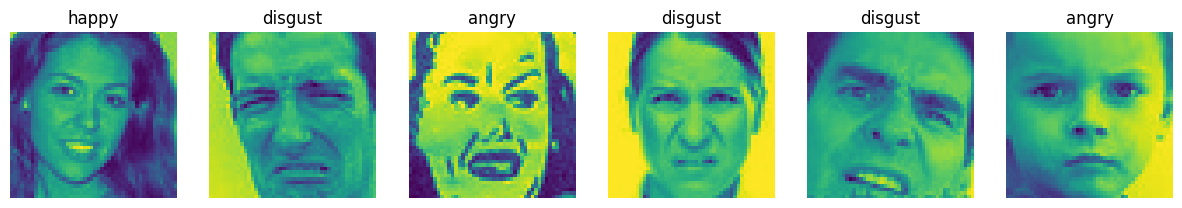

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

def visualize_raw_samples(directory, n=6):
    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        label = random.choice(os.listdir(directory))
        image_file = random.choice(os.listdir(os.path.join(directory, label)))
        image_path = os.path.join(directory, label, image_file)
        image = Image.open(image_path)
        
        axs[i].imshow(image)
        axs[i].set_title(label)
        axs[i].axis('off')

directory_path = '/kaggle/input/fer2013/train/'
visualize_raw_samples(directory_path)


In [2]:
import os
from collections import Counter

def analyze_label_distribution(directory):
    labels = []
    for label in os.listdir(directory):
        images = os.listdir(os.path.join(directory, label))
        labels.extend([label] * len(images))
    
    label_counts = Counter(labels)
    return label_counts

directory_path = '/kaggle/input/fer2013/train/'
label_distribution = analyze_label_distribution(directory_path)
print(label_distribution)


Counter({'happy': 7215, 'neutral': 4965, 'sad': 4830, 'fear': 4097, 'angry': 3995, 'surprise': 3171, 'disgust': 436})


In [3]:
# from PIL import Image

# def find_corrupt_images(directory):
#     corrupt_files = []
#     for label in os.listdir(directory):
#         image_files = os.listdir(os.path.join(directory, label))
#         for image_file in image_files:
#             try:
#                 with Image.open(os.path.join(directory, label, image_file)) as img:
#                     img.verify()
#             except (IOError, SyntaxError) as e:
#                 corrupt_files.append(os.path.join(directory, label, image_file))
#     return corrupt_files

# directory_path = '/kaggle/input/fer2013/train/'
# corrupt_images = find_corrupt_images(directory_path)
# print(f"Found {len(corrupt_images)} corrupt images")


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

class FacialExpressionsDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = []
        self.labels = []

        for label in os.listdir(directory):
            for image_file in glob.glob(os.path.join(directory, label, '*.jpg')):
                self.images.append(image_file)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        label_to_idx = {'happy': 0, 'sad': 1, 'angry': 2, 'disgust': 3, 'fear': 4, 'surprise': 5, 'neutral': 6}
        label_idx = label_to_idx[label]

        return image, label_idx
# mu, st = 0, 255

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ),(0.5, ))
])

test_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ),(0.5, ))
])
# train_transform = transforms.Compose([
#             transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
#             transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),

# #             transforms.TenCrop(40),
#             transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
#             transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
#             transforms.Lambda(lambda tensors: torch.stack([transforms.RandomErasing(p=0.5)(t) for t in tensors])),
# ])

# test_transform =   test_transform = transforms.Compose([
#         # transforms.Scale(52),
#         transforms.TenCrop(40),
#         transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
#         transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
#     ])
train_dataset = FacialExpressionsDataset(directory='/kaggle/input/fer2013/train/', transform=transform)
test_dataset = FacialExpressionsDataset(directory='/kaggle/input/fer2013/test/', transform=test_transform)


val_size = int(len(train_dataset) * 0.1)
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, drop_last=True)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.bias = bias
        self.activation = nn.Tanh()
        self.fc_attention = nn.Linear(step_dim, step_dim)

        
        self.weights = nn.Parameter(torch.Tensor(feature_dim, 1))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(1))
        else:
            self.register_parameter('bias', None)
        
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.uniform_(self.weights, -0.1, 0.1)
        if self.bias is not None:
            nn.init.constant_(self.bias, 0.0)

    def forward(self, x, mask=None):
        e = torch.mm(x.contiguous().view(-1, self.feature_dim), self.weights) + self.bias
        e = self.activation(e)
        e = e.view(-1, self.step_dim)

        
        a = torch.softmax(e, dim=1)
        
        if mask is not None:
            a = a * mask
            a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        weighted_input = x * a.unsqueeze(2)
        return torch.sum(weighted_input*x, 1)

# # Usage
# feature_dim = 128  # Feature dimension of each time step
# step_dim = 10      # Number of time steps
# attn = Attention(feature_dim, step_dim)
# inputs = torch.randn(32, step_dim, feature_dim)  # Batch size of 32
# output = attn(inputs)


In [6]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 16 00:12:24 2020

@author: NAT
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'VGG8':  [64, 'M', 128, 'M', 256, 256, 'M', 512, 'M']  # VGG8 configuration

}


class VGG(nn.Module):
    def __init__(self, vgg_name, num_classes, input_size, hidden_size, num_layers):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 7)
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        
        self.attention = Attention(128, 1)
        # Fusion and fully connected layers
        self.fusion_size = 512 + hidden_size  # VGG features size (512) + LSTM attended features size
        self.dense1 = nn.Linear(self.fusion_size, 128)
        self.relu = nn.ReLU()
        self.output = nn.Linear(128, num_classes)

    def forward(self, x):
#         print(x.size())
        vgg_features = self.features(x)
        vgg_features = vgg_features.view(vgg_features.size(0), -1)
        # Pass VGG features through two additional fully connected layers
#         vgg_features = self.relu(self.fc1(vgg_features))
        vgg_features = self.relu(self.fc2(vgg_features))

        # LSTM and attention
        output, (hidden, cell) = self.lstm(x.view(x.size(0), -1, x.size(2) * x.size(3)))
#         print(output.size())
        
        attn = self.attention(output)
#         print(attn, attn.size())
        fused_features = torch.cat((vgg_features, attn), dim=1)

        # Dense layers
        hdense = self.relu(self.dense1(fused_features))
        x = self.output(hdense)
        return x

    def _make_layers(self, cfg):
        layers = []
        in_channels = 1
        
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
#                            nn.Dropout(0.2)]  
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [7]:
# class FocalLoss(nn.Module):
#     def __init__(self, gamma=2.0, alpha, reduction='mean'):
#         super(FocalLoss, self).__init__()
#         self.gamma = gamma
#         self.alpha = alpha
#         self.reduction = reduction

#     def forward(self, inputs, targets):
#         BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
#         pt = torch.exp(-BCE_loss)  # prevents nans when probability 0
#         F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

#         if self.reduction == 'mean':
#             return torch.mean(F_loss)
#         elif self.reduction == 'sum':
#             return torch.sum(F_loss)
#         else:
#             return F_loss

# class FocalLoss(nn.Module):
#     def __init__(self, gamma=2.0, alpha=None, weight=None, reduction='mean'):
#         super(FocalLoss, self).__init__()
#         self.gamma = gamma
#         self.alpha = alpha  # must be a tensor with the same size as the number of classes
#         self.weight = weight  # can be used if you want to specify weight for each class
#         self.reduction = reduction

#     def forward(self, inputs, targets):
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weight)
#         pt = torch.exp(-ce_loss)
#         if self.alpha is not None:
#             alpha_factor = self.alpha[targets]
#             ce_loss = alpha_factor * ce_loss
#         focal_loss = ((1 - pt) ** self.gamma) * ce_loss

#         if self.reduction == 'mean':
#             return focal_loss.mean()
#         elif self.reduction == 'sum':
#             return focal_loss.sum()
#         else:
#             return focal_loss


In [8]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # Ensure alpha is a tensor with weights for each class
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')  # Shape [batch_size]
        pt = torch.exp(-ce_loss)  # Shape [batch_size]
#         print(targets)
        if self.alpha is not None:
            if isinstance(self.alpha, torch.Tensor):
                alpha_factor = self.alpha[targets]  # Use indexed alpha values if alpha is a tensor
            else:
                alpha_factor = torch.full_like(ce_loss, fill_value=self.alpha)  # Scalar alpha for all
        else:
            alpha_factor = 1.0  # Default to 1.0 if alpha is not provided

        # Apply the focal loss formula
        focal_loss = (alpha_factor * (1 - pt) ** self.gamma * ce_loss)

        # Apply reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [9]:
def to_one_hot(targets, num_classes):
    evice = targets.device
    return torch.eye(num_classes, device='cuda')[targets]

In [10]:
num_classes = 7

input_size = 48*48
hidden_size = 128
num_layers = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = DCRAN(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)
model = VGG('VGG11', num_classes, input_size, hidden_size, num_layers).to(device)
# criterion = nn.CrossEntropyLoss()
alpha = torch.tensor([1.0, 1.0 ,1.1,1.3, 1.1,1.0,1.0]).to(device)

# criterion = FocalLoss(gamma=2.0, alpha=alpha)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay = 0.0001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


In [ ]:
pip install torchinfo

In [ ]:
print(model)

In [ ]:
from torchinfo import summary

# Assume 'model' is your PyTorch model and 'device' is your device (either 'cuda' or 'cpu')
model.to(device)
summary(model, input_size=(32, 1, 48, 48))


In [12]:
def validate_model(model, criterion, data_loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
#             targets_one_hot = to_one_hot(labels, num_classes).to(device)
#             loss = criterion(outputs, targets_one_hot)
            _, predicted = torch.max(outputs, 1)
            
            running_loss += loss.item()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            
    avg_loss = running_loss / len(data_loader)
    avg_acc = correct_predictions / total_predictions * 100
    return avg_loss, avg_acc

def train_and_validate_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    best_accuracy = 0.0
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    test_losses = []
    test_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
#             targets_one_hot = to_one_hot(labels, num_classes).to(device)
            loss = criterion(outputs, labels)
#             loss = criterion(outputs, targets_one_hot)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_predictions / total_predictions * 100
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        val_loss, val_acc = validate_model(model, criterion, val_loader)
        test_loss, test_acc = validate_model(model, criterion, test_loader)

        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        test_losses.append(test_loss)
        test_accs.append(test_acc)
#         scheduler.step()

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%'
              f'Test loss: {test_loss:4f}, Test acc: {test_acc:.2f}%')

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            torch.save(model.state_dict(), 'best_model.pth')

    print('Finished Training')
    return train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accs

train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accs = train_and_validate_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=30)


Epoch 1/30, Train Loss: 1.2860, Train Acc: 50.82%, Val Loss: 1.2272, Val Acc: 53.23%Test loss: 1.205343, Test acc: 53.57%
Epoch 2/30, Train Loss: 1.2057, Train Acc: 54.23%, Val Loss: 1.1693, Val Acc: 55.41%Test loss: 1.170600, Test acc: 55.11%
Epoch 3/30, Train Loss: 1.1475, Train Acc: 56.43%, Val Loss: 1.0939, Val Acc: 58.46%Test loss: 1.101765, Test acc: 57.37%
Epoch 4/30, Train Loss: 1.1071, Train Acc: 58.01%, Val Loss: 1.0459, Val Acc: 60.04%Test loss: 1.063407, Test acc: 59.82%
Epoch 5/30, Train Loss: 1.0744, Train Acc: 59.35%, Val Loss: 1.0249, Val Acc: 60.43%Test loss: 1.057904, Test acc: 59.60%
Epoch 6/30, Train Loss: 1.0379, Train Acc: 60.74%, Val Loss: 1.0271, Val Acc: 60.85%Test loss: 1.076313, Test acc: 59.40%
Epoch 7/30, Train Loss: 1.0164, Train Acc: 61.56%, Val Loss: 0.9708, Val Acc: 63.20%Test loss: 1.044247, Test acc: 60.84%
Epoch 8/30, Train Loss: 0.9925, Train Acc: 62.70%, Val Loss: 0.9881, Val Acc: 62.11%Test loss: 1.052753, Test acc: 60.35%
Epoch 9/30, Train Loss: 

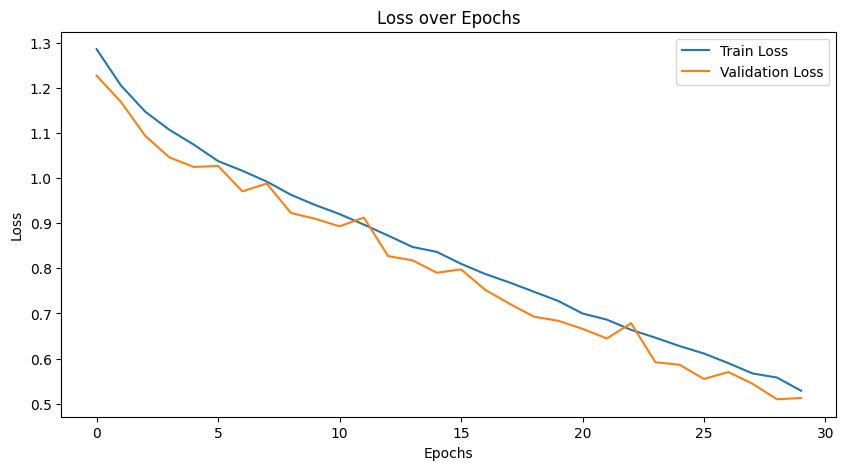

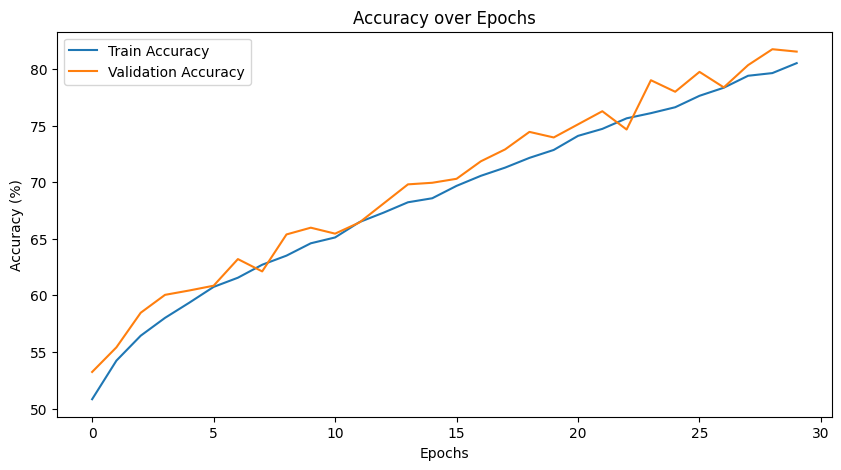

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

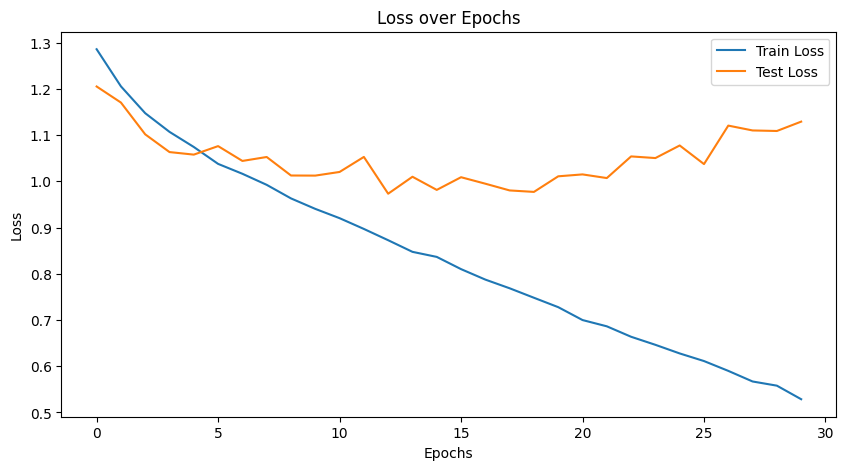

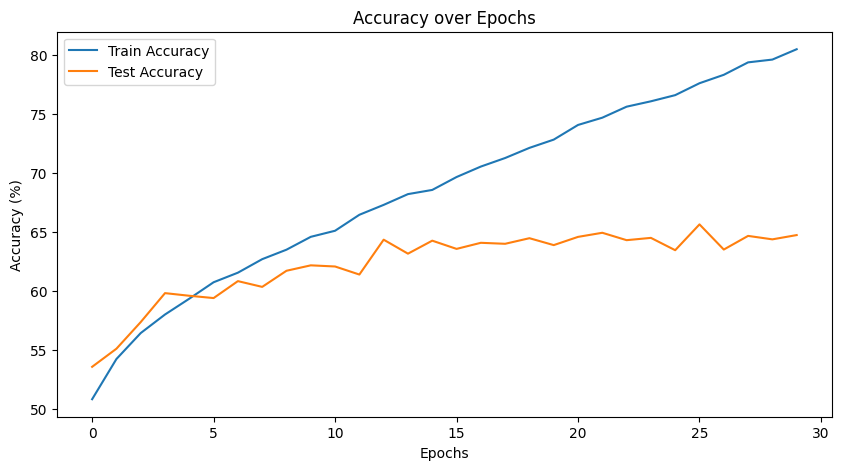

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

Accuracy of the model on the test images: 65.65%


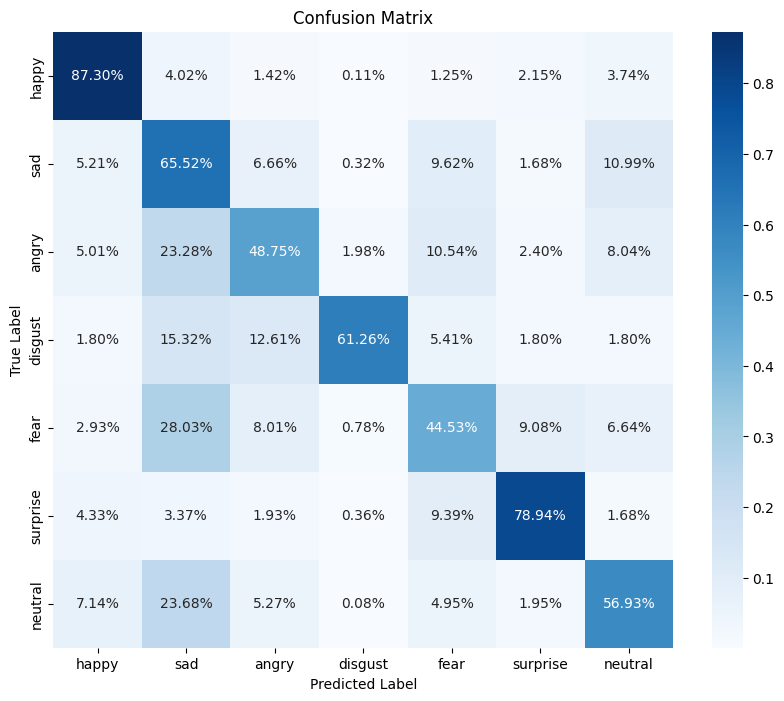

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_on_test(test_loader, model_path='/kaggle/working/best_model.pth'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = VGG('VGG11', num_classes, input_size, hidden_size, num_layers).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predicted.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predicted)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap='Blues', xticklabels=label_to_idx.keys(), yticklabels=label_to_idx.keys())
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Assuming you have a dictionary for class labels
label_to_idx = {'happy': 0, 'sad': 1, 'angry': 2, 'disgust': 3, 'fear': 4, 'surprise': 5, 'neutral': 6}

# Evaluate the model on the test set
evaluate_on_test(test_loader)